In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c cassava-leaf-disease-classification

... resuming from 592445440 bytes (5593216980 bytes left) ...
100% 5.74G/5.76G [00:55<00:00, 138MB/s]
100% 5.76G/5.76G [00:55<00:00, 99.9MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cassava-leaf-disease-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
#%% IMPORTING LIBRARIES

import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Defining the working directories

# work_dir = '/content/cassava-leaf-disease-classification.zip'
# os.listdir(work_dir)
train_path = '/content/train_images'

In [ ]:
#%% IMPORTING DATA

# Importing train.csv

data = pd.read_csv('train.csv')
print(Counter(data['label'])) # Checking the frequencies of the labels

Counter({3: 13158, 4: 2577, 2: 2386, 1: 2189, 0: 1087})


In [ ]:
# Importing the json file with labels

f = open(  'label_num_to_disease_map.json')
real_labels = json.load(f)
real_labels = {int(k):v for k,v in real_labels.items()}

# Defining the working dataset
data['class_name'] = data.label.map(real_labels)
print(data.head(10))
print(data['class_name'].unique())

         image_id  label                           class_name
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)
5  1000837476.jpg      3         Cassava Mosaic Disease (CMD)
6  1000910826.jpg      2           Cassava Green Mottle (CGM)
7  1001320321.jpg      0       Cassava Bacterial Blight (CBB)
8  1001723730.jpg      4                              Healthy
9  1001742395.jpg      3         Cassava Mosaic Disease (CMD)
['Cassava Bacterial Blight (CBB)' 'Cassava Mosaic Disease (CMD)'
 'Cassava Brown Streak Disease (CBSD)' 'Cassava Green Mottle (CGM)'
 'Healthy']


In [ ]:
def showImages(images):

    # Extract 16 random images from it
    random_images = [np.random.choice(images) for i in range(16)]

    # Adjust the size of your images
    plt.figure(figsize=(16,12))

    # Iterate and plot random images
    for i in range(16):
        plt.subplot(4,4, i + 1)
        img = plt.imread(train_path+'/'+random_images[i])
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    # Adjust subplot parameters to give specified padding
    plt.tight_layout()

In [ ]:
mask = data['label'] ==4
classHealthy = data[mask]

In [ ]:
mask = data['label'] ==3
classCMD = data[mask]

In [ ]:
mask = data['label'] ==2
classCGM = data[mask]

In [ ]:
mask = data['label'] ==1
classCBSD = data[mask]

In [ ]:
mask = data['label'] ==0
classCBB = data[mask]

In [ ]:
class0 = classCBB.sample(frac=0.99)
class1 = classCBSD.sample(frac=0.9)
class2 = classCGM.sample(frac=0.9)
class3 = classCMD.sample(frac=0.9)
class4 = classHealthy.sample(frac=0.9)




frames=[class0,class1,class2,class3,class4]
finalData = pd.concat(frames)
finalData.head(10)
print(len(finalData))

# Spliting the data
from sklearn.model_selection import train_test_split

train,val = train_test_split(finalData, test_size = 0.05, random_state = 42, stratify = finalData['class_name'])

# Importing the data using ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (32, 32)  # Adjusted image size

datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255  # Add rescaling for grayscale images
)

train_set = datagen.flow_from_dataframe(train,
                                        directory=train_path,
                                        seed=42,
                                        x_col='image_id',
                                        y_col='class_name',
                                        target_size=IMG_SIZE,
                                        color_mode='grayscale',  # Set color mode to grayscale
                                        class_mode='categorical',
                                        interpolation='nearest',
                                        shuffle=True,
                                        batch_size=32)

val_set = datagen.flow_from_dataframe(val,
                                      directory=train_path,
                                      seed=42,
                                      x_col='image_id',
                                      y_col='class_name',
                                      target_size=IMG_SIZE,
                                      color_mode='grayscale',  # Set color mode to grayscale
                                      class_mode='categorical',
                                      interpolation='nearest',
                                      shuffle=True,
                                      batch_size=32)


19354
Found 18386 validated image filenames belonging to 5 classes.
Found 968 validated image filenames belonging to 5 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def create_lenet_model():
    model = Sequential()

    # Convolutional layer 1
    model.add(Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 1)))
    model.add(MaxPooling2D((2, 2)))

    # Convolutional layer 2
    model.add(Conv2D(16, (5, 5), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    return model

def Model_fit(train_set, val_set, EPOCHS=10):
    leaf_model = create_lenet_model()

    leaf_model.compile(optimizer=Adam(learning_rate=2e-4),
                       loss='categorical_crossentropy',
                       metrics=['categorical_accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', patience=5,
                       restore_best_weights=True, verbose=1)

    checkpoint_cb = ModelCheckpoint("LeNet_best_model.h5",
                                    save_best_only=True,
                                    monitor='val_loss',
                                    mode='min')

    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.3,
                                  patience=3,
                                  min_lr=1e-6,
                                  mode='min',
                                  verbose=1)

    history = leaf_model.fit(train_set,
                             validation_data=val_set,
                             epochs=EPOCHS,
                             batch_size=32,
                             callbacks=[es, checkpoint_cb, reduce_lr])

    leaf_model.save('LeNet_model.h5')

    return history


In [ ]:
history = Model_fit(train_set, val_set)

Epoch 1/10
575/575 [==============================] - 141s 237ms/step - loss: 1.1922 - categorical_accuracy: 0.6048 - val_loss: 1.1822 - val_categorical_accuracy: 0.6116 - lr: 2.0000e-04
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


575/575 [==============================] - 107s 186ms/step - loss: 1.1633 - categorical_accuracy: 0.6119 - val_loss: 1.1962 - val_categorical_accuracy: 0.6116 - lr: 2.0000e-04
Epoch 3/10
575/575 [==============================] - 110s 192ms/step - loss: 1.1559 - categorical_accuracy: 0.6123 - val_loss: 1.1676 - val_categorical_accuracy: 0.6116 - lr: 2.0000e-04
Epoch 4/10
575/575 [==============================] - 105s 183ms/step - loss: 1.1429 - categorical_accuracy: 0.6141 - val_loss: 1.1354 - val_categorical_accuracy: 0.6126 - lr: 2.0000e-04
Epoch 5/10
575/575 [==============================] - 107s 186ms/step - loss: 1.1372 - categorical_accuracy: 0.6154 - val_loss: 1.1392 - val_categorical_accuracy: 0.6147 - lr: 2.0000e-04
Epoch 6/10
575/575 [==============================] - 106s 184ms/step - loss: 1.1292 - categorical_accuracy: 0.6173 - val_loss: 1.1399 - val_categorical_accuracy: 0.6167 - lr: 2.0000e-04
Epoch 7/10
575/575 [==============================] - 109s 189ms/step - loss

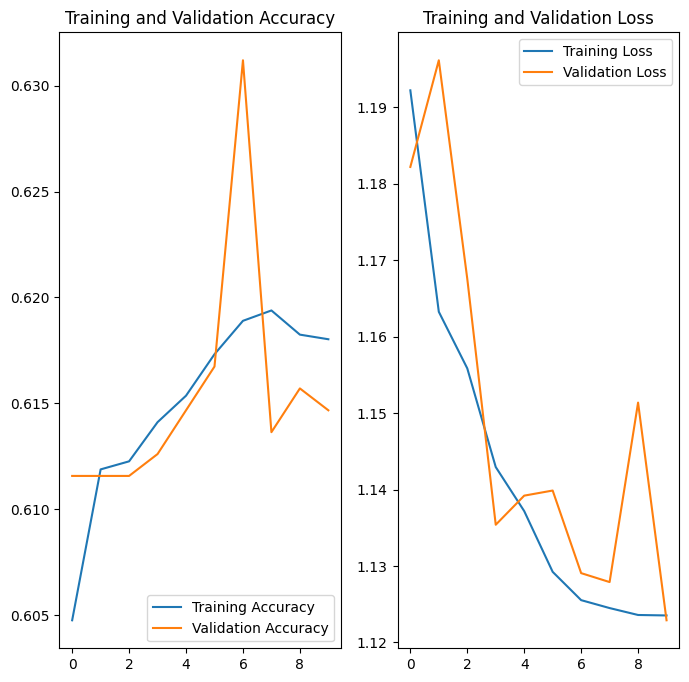

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Corrected line
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:

import keras

final_model_lenet = keras.models.load_model('LeNet_model.h5')


In [ ]:
import glob
from PIL import Image
import numpy as np
import os

TEST_DIR = '/content/test_images'
test_images = glob.glob(os.path.join(TEST_DIR, "*.jpg")) + glob.glob(os.path.join(TEST_DIR, "*.png"))+ glob.glob(os.path.join(TEST_DIR, "*.jpeg"))
predictions = []
IMG_SIZE = 32
size = (IMG_SIZE, IMG_SIZE)

for image in test_images:
    img = Image.open(os.path.join(TEST_DIR, image))  # Load the image using PIL
    img = img.convert('L')  # Convert the image to grayscale
    img = img.resize(size)  # Resize the image
    img = np.expand_dims(np.array(img), axis=0)  # Convert the image to numpy array and add a batch dimension

    prediction = final_model_lenet.predict(img)  # Make predictions using the LeNet model
    predictions.extend(prediction.argmax(axis=1))

print(predictions)


1/1 [==============================] - 0s 35ms/step
[3, 3, 3]


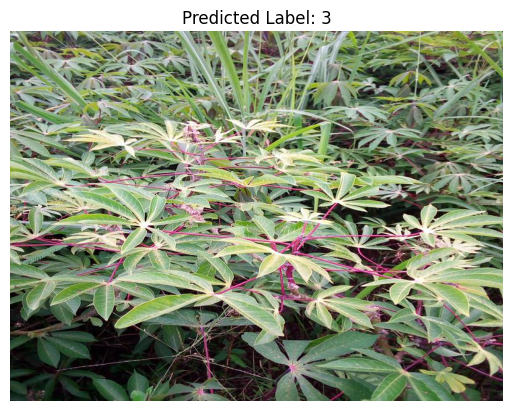

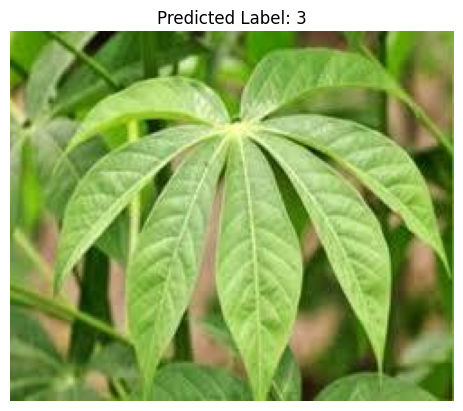

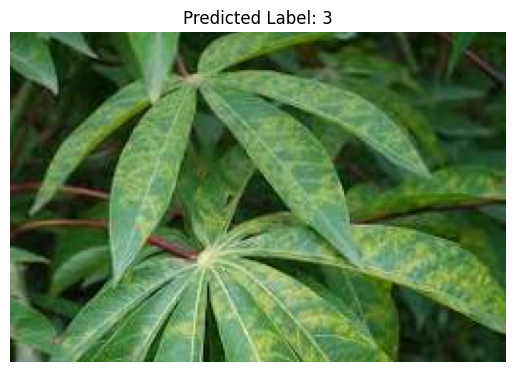

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already imported necessary libraries and defined variables

# Iterate over each test image and its corresponding prediction
for image_path, prediction in zip(test_images, predictions):
    # Load and display the image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')

    # Set the title as the predicted label
    plt.title(f'Predicted Label: {prediction}')

    # Show the image with the predicted label
    plt.show()
